# Lecture 4: Data Analysis with Qinfer (1.5 hours) #

**TODO**: relevant Qinfer links

In this notebook, we will introduce Bayesian parameter estimation and the sequential Monte Carlo algorithm implemented by **Qinfer**. 


### Preamble

Here we import all the necessary modules as well as make the code compatible with Python 2.7.

In [5]:
from __future__ import division, print_function

import qinfer as qi
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#%matplotlib notebook
# Use nice plotting defaults if available.
try: plt.style.use('ggplot')
except: pass

from ipywidgets import interact, interactive, fixed, FloatProgress
from IPython.display import display, clear_output
from time import sleep

## Starting simple: estimating the bias of a coin

Suppose we have a coin that we do not know the bias $p$ of. We will guess what $p$ is by flipping the coin many times. 

If we knew the bias, we could determine the exact distribution of the number of "Heads" we would see. If we label the number of flips $N$ and the number of heads $n$, then the distribution of $n$ is a [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution):
$$
\operatorname{Pr}(n|p) = \binom{N}{n} p^n (1-p)^{N-n}.
$$

Now suppose we have flipped the coin and $n$ heads did actually occur in $N$ flips. What is the distribution of $p|n$? The answer is given by [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_theorem):
$$
\operatorname{Pr}(n|p) = \frac{\operatorname{Pr}(n|p)\operatorname{Pr}(p)}{\operatorname{Pr}(n)},
$$
where $\operatorname{Pr}(n|p)$ is called the likelihood function, $\operatorname{Pr}(p)$ the prior, $\operatorname{Pr}(p|n)$ the posterior and $\operatorname{Pr}(n)$ is called the evidence. The likelihood function we have determined above. The prior is the input to the problem and the evidence can be determined by normalization of probability.

The input, the prior, can be anything. A typical choice for generic problems is the uniform prior $\operatorname{Pr}(p) = 1/V$, where $V$ is the volume of the parameter space, in this case $V = 1$ since the bias can be between 0 and 1. For the uniform prior, the posterior is
$$
\operatorname{Pr}(p|n) = \frac{p^n (1-p)^{N-n}}{B(n+1,N-n+1)},
$$
where $B$ is the Beta function. (See a derivation of a slightly more general form [here](https://en.wikipedia.org/wiki/Conjugate_prior#Example)).

For more complicated models, such an analytic solution is not obtainable and we must turn to numerical algorithms. The algorithm we use is called [sequential Monte Carlo or the particle filter](https://en.wikipedia.org/wiki/Particle_filter). We begin by drawing $k$ samples $\{p_i\}$ from the prior and approximating it as
$$
\operatorname{Pr}(p) = \frac{1}{k}\sum_{i=1}^k \delta(p-p_i).
$$
The samples are called particles. Each particle is associated a weight $w_i$ which is conventionally set to be $1/k$ initially. The weights are updated via Bayes rule as follows:
$$
w_i(n) \mapsto \Pr(n|p_i)/k.
$$
The set of weights $\{w_i(n)\}$ are not normalized so we make one final assignment
$$
w_i(n) \mapsto \frac{w_i(n)}{\sum_j w_j(n)}.
$$
Then the posterior is approximated by
$$
\operatorname{Pr}(p|n) = \sum_{i=1}^k w_i(n) \delta(p-p_i).
$$

That's it; that's the basics! Now we will go through it a little more slowly using numpy, scipy and qinfer.

### Flipping coins

Suppose we flip our coin 10 times. What does $\operatorname{Pr}(n|p)$ look like?

In [ ]:
# Create a variable for the number of flips (go ahead and change this if you want).
N = 10
# This creates an array containing [0, 1, ..., N].
n = np.arange(0, N + 1)

# This sets up the figure as an matrix of subfigures with 1 row and 3 columns.
fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
# This is the probability mass function (pmf) of the binomial distribution for p = 0.
dist = sp.stats.binom.pmf(n, N, 0)
# On the first (0 indexed!) subplot, make a bar plot with x-axis given by the array n and y-axis given by the pmf.
axarr[0].bar(n, dist)

# The rest is just annotation and repeating for different biases.
axarr[0].set_xlabel("$n$")
axarr[0].set_ylabel("$\operatorname{Pr}(n|p)$")
axarr[0].set_title("$p=0$")

dist = sp.stats.binom.pmf(n, N, 0.1)
axarr[1].bar(n, dist)
axarr[1].set_xlabel("$n$")
axarr[1].set_title("$p=0.1$")

dist = sp.stats.binom.pmf(n, N, 0.5)
axarr[2].bar(n, dist)
axarr[2].set_xlabel("$n$")
axarr[2].set_title("$p=0.5$")

plt.show()

In reality, we often have data, in this case $n$, so we are interested not in $\operatorname{Pr}(n|p)$ but in $\operatorname{Pr}(p|n)$. We still use $\operatorname{Pr}(n|p)$ in Bayes' rule but think of it as a function of $p$ for fixed data $n$. Below we plot what that looks like.

In [ ]:
 # This creates an array with 100 values between 0 and 1.
p = np.linspace(0, 1, 100)

fig, axarr = plt.subplots(1, 3, figsize=(15,5))
likelihood = sp.stats.binom.pmf(0, N, p)
axarr[0].plot(p, likelihood)
axarr[0].set_xlabel("$p$")
axarr[0].set_ylabel("$\operatorname{Pr}(n|p)$")
axarr[0].set_title("$n=0$")

likelihood = sp.stats.binom.pmf(1, N, p)
axarr[1].plot(p, likelihood)
axarr[1].set_xlabel("$p$")
axarr[1].set_title("$n=1$")

likelihood = sp.stats.binom.pmf(5, N, p)
axarr[2].plot(p, likelihood)
axarr[2].set_xlabel("$p$")
axarr[2].set_title("$n=5$")

plt.show()

Bayes' rule states:
$$
\operatorname{Pr}(p|n) = \frac{\operatorname{Pr}(n|p)\operatorname{Pr}(p)}{\operatorname{Pr}(n)} = \frac{p^n (1-p)^{N-n}}{B(n+1,N-n+1)},
$$
For the uniform prior $\operatorname{Pr}(p) = 1$. Since this is just proportional to $\operatorname{Pr}(p|n)$ we should expect the posterior to look the same.

(Note that $\operatorname{Pr}(p|n)$ is not strictly a probability, but a density, or measure, and can be greater than 1 for any particular value of $p$ since only questions about the probability over intervals return non-zero answers.)

In [ ]:
# Rather than write it out many times, we define a function to compute the posterior which compresses further code.
def posterior(p, n, N):
    return p ** n * (1 - p) ** (N - n) / sp.special.beta(n + 1, N - n + 1)

# Note that notebooks have access to the variables defined in previous run cells, so we do not need to redefine N and p.
fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
axarr[0].plot(p, posterior(p, 0, N))
axarr[0].set_xlabel("$p$")
axarr[0].set_ylabel("$\operatorname{Pr}(p|n)$")
axarr[0].set_title("$n=0$")

axarr[1].plot(p, posterior(p, 1, N))
axarr[1].set_xlabel("$p$")
axarr[1].set_title("$n=1$")

axarr[2].plot(p, posterior(p, 5, N))
axarr[2].set_xlabel("$p$")
axarr[2].set_title("$n=5$")

plt.show()

### QInfer

Now we will demonstrate how to use qinfer to get a numerical approximation to the posterior. The first task is create a `Model`.

In [ ]:
# We create a model which is abstracted by the Model class, which already implements common methods 
# among models and templates what such a class needs to look like

class CoinFlipsModel(qi.FiniteOutcomeModel):
    
    # This function is called when an instance of this class is instantiated.
    def __init__(self):
        # Make sure all the necessary functionality in the Model class is brought over.
        super(CoinFlipsModel, self).__init__()
        
    # The following are functions that are required for the functionality of QInfer.
    
    @property
    def n_modelparams(self):
        # The dimension of the parameter space.
        return 1 # In this case, it is just the bias p.
    
    @property
    def expparams_dtype(self):
        # many models will have complicated experiment design descriptions. Here, it is just the number of flips.
        return int # The number of flips is an integer.
    
    @property
    def is_n_outcomes_constant(self):
        # We tell QInfer that the number of outcomes
        # depends on which experiment we want to perform.
        return False
    
    def n_outcomes(self, expparams):
        # The number of outcomes are needed to numerically simulate experiments.
        return expparams + 1 # the number of flips + 1
    
    def are_models_valid(self, modelparams):
        # Make sure any boundaries in the parameter space are respected.
        # In this case, the modelparams array is a bias, which must be between 0 and 1.
        return np.logical_or(modelparams >= 0, modelparams <= 1)[:, 0]
    
    def likelihood(self, outcomes, modelparams, expparams):
        # Finally, we calculate the likelihood function
        # Again, call some necessary internal functions.
        super(CoinFlipsModel,self).likelihood(outcomes, modelparams, expparams)
        
        # The tensor storing the values of the likelihood has the following expected shape.
        like = np.zeros([outcomes.shape[0], modelparams.shape[0], 1])
        
        # scipy.stats.binom can vectorize over one of its arguments so we'll have to loop over the other
        for idx in range(outcomes.shape[0]):
            like[idx] = sp.stats.binom.pmf(outcomes[idx], expparams, modelparams)
            
        return like

Now that is a bit overkill for such a simple problem, but the functionality is there really for more "interesting" models. But we can see that calling `model.likelihood` gives the correct results.

In [ ]:
model = CoinFlipsModel() # This instantiates the model we just defined.

# Recall that model.expparams_dtype was int and we defined N to be an integer above.
expparams = np.array([N], dtype=int)
# In the model we asked for outcomes.shape[0], so we have to define it as an object with a shape!
outcome = np.array([0])

fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
# Note that modelparams are expected to have at least 2D shape;
# indexing by None adds an axis to the (100,) array we defined above for p.
axarr[0].plot(p, model.likelihood(outcome, p[:, None], expparams)[0, :, 0]) 
axarr[0].set_xlabel("$p$")
axarr[0].set_ylabel("$\operatorname{Pr}(n|p)$")
axarr[0].set_title("$n=0$")

outcome = np.array([1])
axarr[1].plot(p, model.likelihood(outcome, p[:, None], expparams)[0, :, 0])
axarr[1].set_xlabel("$p$")
axarr[1].set_title("$n=1$")

outcome = np.array([5])
axarr[2].plot(p, model.likelihood(outcome, p[:, None], expparams)[0, :, 0])
axarr[2].set_xlabel("$p$")
axarr[2].set_title("$n=5$")

plt.show()

The next step is creating a distribution. For most (and by most, I mean nearly all) distributions used in practice, there is built-in functionality. In particular, the uniform prior discussed above is defined in QInfer as follows. 

In [ ]:
# This instantiates the built-in uniform prior over the interval [0, 1].
prior = qi.UniformDistribution([0, 1])
# prior.sample() returns a single randomly drawn sample.
print(prior.sample())

The last thing to do is define an `SMCUpdater` which implements the sequential Monte Carlo algorithm. An `SMCUpdater` takes a `model` and `prior` and then its `update` function takes data and experiment parameters to produce the posterior distribution. The number of particles used controls the approximation.

In [ ]:
# The number of particles we will use.
n_particles = 1000

# Instantiates an updater, takes the model and prior we defined above.
updater = qi.SMCUpdater(model, n_particles, prior)

OK, now we can plug in some data and see how well it does.

In [ ]:
# In the model we asked for outcomes.shape[0], so we have to define it as an object with a shape!
outcome = np.array([5])

# Call the update function to change the state of the updater, now it stores the posterior.
updater.update(outcome, expparams)

plt.figure(figsize=(10, 5))

plt.plot(p, posterior(p, 5, N), label = 'True Posterior')
updater.plot_posterior_marginal(smoothing=0.075, other_plot_args={'label': 'QInfer approximation'})

plt.xlabel("$p$")
plt.ylabel("$\operatorname{Pr}(n|p)$")

plt.legend()

Not bad! Now go forth and multiply... likelihoods by priors.

# What did we just do? Qinfer!

You can see that Qinfer is numerical algorithm to approximate Bayesian inference. Broadly speaking, we treat Bayesian inference as the problem of inferring a set of parameters $\boldsymbol{x} \in \mathbb R^n$ from data conditioned on an experiment. That is, we want to know what $\Pr(\boldsymbol{x}|d,e)$ is. Data are generated from a distribution given by a physical model that is known: $\Pr(d|\boldsymbol{x},e)$. In order to compute this, we also need a prior $\Pr(\boldsymbol{x})$.

Qinfer mirrors these objects with the following classes
* **qinfer.Distribution** Represents drawing samples from a prior distribution.
* **qinfer.Model** Represents evaluation of the likelihood function.
* **qinfer.SMCUpdater** Represents Bayesian updating via the particle filtering algorithm.

Qinfer implements many commonly used distributions and models used in quantum information science, including
* quantum state tomography
* phase estimation
* randomized benchmarking

We'll jump right back into the deep end and learn how to use Qinfer to solve problems in these domains.

# Quantum state tomography

To define the model, we start with a basis for traceless Hermitian operators
$\{B_j\}_{j=1}^{d^2-1}$.  In the case of a qubit, this could be the basis of
Pauli matrices, for example.  Then, any state $\rho$ can be written
$$
    \rho = \frac{I}{d}+\sum_{j=1}^{d^2-1} \theta_j B_j,
$$
for some vector of parameters $\vec\theta$. These parameters must be constrained such that $\rho\geq0$. Defining a basis turns the quantum problem into an effectively classical one.

Qinfer's `TomographyModel` abstracts many of the implementation
details of this problem, exposing tomographic models and estimates in terms
of Qutip objects, which you will learn about next lecture. For now, the added functionality provided by Qutip will be hidden.

Tomography support in Qinfer requires one of the bases mentioned above in
order to parameterize the state. Many common choices of basis are included as
`TomographyBasis` objects, such as the [Pauli](https://en.wikipedia.org/wiki/Pauli_matrices) or [Gell-Mann](https://en.wikipedia.org/wiki/Gell-Mann_matrices) bases.

Let us look at an example for a single qubit. Take the Pauli basis:
$$
    \{\sigma_x/\sqrt{2}, \sigma_y/\sqrt{2}, \sigma_z/\sqrt{2}\}.
$$
As written above, any state can now be describe by 3 real numbers $(x,y,z)$, often called the Bloch vector, as follows:
$$
    \rho = 1/\sqrt{2}\left(\frac{I}{\sqrt{2}} + x\sigma_x +y\sigma_y + z\sigma_z\right).
$$

Many of the most commonly used priors are already implemented as a `Distribution`. Here we will focus on the `GinibreDistribution` because is most closely resembles the "flat" prior.

In [ ]:
basis = qi.tomography.pauli_basis(1)
prior = qi.tomography.distributions.GinibreDistribution(basis)

REbits

In [ ]:
qi.tomography.plot_rebit_prior(prior, rebit_axes=[1, 3])

In the simplest case, we can consider two-outcome measurements represented
by the pair $\{E,I-E\}$.  The Born rule defines the likelihood function
$$
     \Pr(E|\rho)=\operatorname{Tr}(\rho E).
$$
For multiple measurements, we simply iterate.  For many trials of the same
measurement, we can use a *derived model* as discussed below.


For simulations, common randomized measurement choices are already
implemented. For example, `RandomPauliHeuristic` chooses random
Pauli measurements for qubit tomography.

# Phase estimation

Consider the following setup. The qubit begins in the state $|+\rangle = |0\rangle + |1\rangle$ and is subject to the gate $U(t) = \exp(- j \omega t \sigma_z /2)$, where $t$ is time and $\omega$ is a parameter which controls how strongly the qubit is coupled to some external degrees of freedom. Thinking about the Bloch sphere, the state starts pointing along the positive $x$-axis and rotates in the $x$-$y$ plane. The angle of rotation, which we call the *phase*, is $\theta = \omega t$. That is, the state becomes
$$
U(t)|+\rangle = \cos(\omega t /2 ) |+\rangle - j \sin(\omega t /2) |-\rangle.
$$
Finally, we measure in the basis $\{|+\rangle,|-\rangle\}$, for which the probability is
$$
\Pr(+|\omega,t) = \cos^2(\omega t/2).
$$

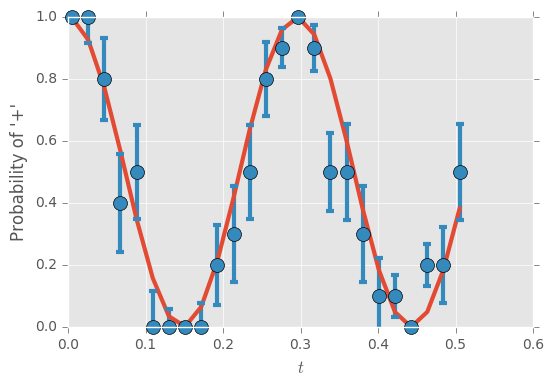

In [18]:
fig = plt.figure()

omega_max = 100
true_omega = 21.3
ts = np.linspace(1, 101,25) / (2 * omega_max)

ps = np.cos(true_omega * ts / 2) ** 2

n_counts = 10
counts = np.random.binomial(n_counts, ps)

plt.plot(ts,ps, linewidth = 3, clip_on=False)
plt.errorbar(ts,counts/n_counts,np.sqrt(ps*(1-ps)/n_counts),
             fmt='o',markersize='10',capsize=3, capthick = 3,elinewidth=3, clip_on=False)

plt.ylim([0,1])
plt.ylabel("Probability of '+'")
plt.xlabel("$t$")

plt.show()

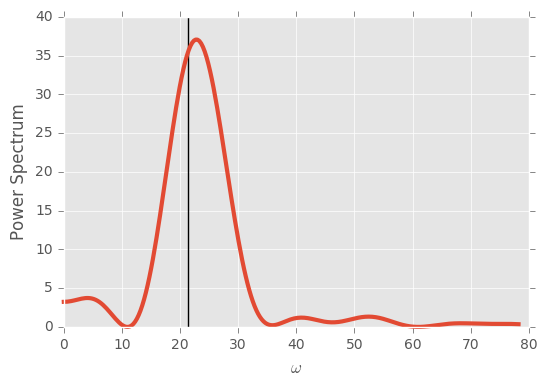

22.7029156607


In [19]:
pow_spec = np.abs(np.fft.rfft(counts/n_counts-0.5,n=1024))**2

omega = np.linspace(0,np.pi*omega_max/2,pow_spec.size)
plt.plot(omega[:int(pow_spec.size/2)],pow_spec[:int(pow_spec.size/2)], linewidth = 3, clip_on=False)

plt.ylabel("Power Spectrum")
plt.xlabel("$\\omega$")

ylim = plt.ylim(ymin=0)
plt.vlines(true_omega, *ylim)
plt.ylim(*ylim);

plt.show()

print(np.argmax(pow_spec)*np.pi*omega_max/1024)

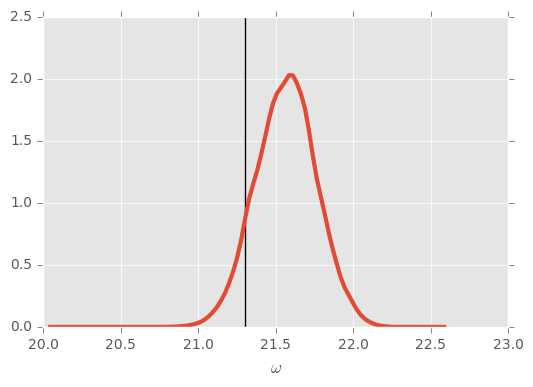

[ 21.56661555] [[ 0.03771898]]


In [22]:
model = qi.BinomialModel(qi.SimplePrecessionModel())
prior = qi.distributions.UniformDistribution([0,100])
updater = qi.SMCUpdater(model,10000,prior)

for idx_exp in range(25):
    expparams = np.array([(ts[idx_exp],n_counts)], dtype = model.expparams_dtype)
    datum = n_counts-counts[idx_exp]
    updater.update(datum,expparams)

updater.plot_posterior_marginal(smoothing=.025, other_plot_args = {'linewidth': 3})

ylim = plt.ylim(ymin=0)
plt.vlines(true_omega, *ylim)
plt.ylim(*ylim);

plt.show()

print(updater.est_mean(),updater.est_covariance_mtx())

In [ ]:
fig = plt.figure()
axe = fig.add_subplot(111)

omega_max = 100
true_omega = 21.3
ts = np.linspace(1, 101,50) / (2 * omega_max)

ps = np.cos(true_omega * ts / 2) ** 2

n_counts = 100

counts = np.zeros_like(ps)
counts = np.random.binomial(1, ps)

axe.plot(ts,ps, linewidth = 3, clip_on=False)
img, = axe.plot(ts,counts,'o',markersize='10', clip_on=False)

prgBar = FloatProgress(min=0, max=n_counts-1)
display(prgBar)

for i in range(n_counts):
    clear_output(wait = True)
    prgBar.value = i
    
    counts += np.random.binomial(1, ps)
    
    img.set_ydata(counts/(i+2))
    display(fig)
    sleep(0.1)

# Randomized Benchmarking

In recent years, randomized benchmarking (RB) has reached a critical role in
evaluating candidate quantum information processing systems. By
using random sequences of gates drawn from the Clifford group, RB provides
a likelihood function that depends on the fidelity with which each Clifford
group element is implemented, allowing for estimates of that fidelity to
be drawn from experimental data.

In particular, suppose that each gate is implemented with fidelity $F$, and
consider a fixed initial state and measurement. Then, the survival
probability over sequences of length $m$ is given by [Magesan, Gambetta and Emerson(2011)](https://arxiv.org/abs/1109.6887):
$$
    \Pr(\text{survival} | p, A, B; m) = A p^m + B,
$$
where $p = (d F - 1) / (d - 1)$, $d$ is the dimension of the system
under consideration, and where $A$ and $B$ describe the state preparation
and measurement (SPAM) errors. Learning the model $\boldsymbol{x} = (p, A, B)$
thus provides an estimate of the fidelity of interest $F$.

The likelihood function for randomized benchmarking is extremely
simple, and requires only scalar arithmetic to compute, making it especially
useful for avoiding the computational overhead typically required to characterize
large quantum systems with classical resources. 

Qinfer supports RB experiments through the
`RandomizedBenchmarkingModel` class. For common priors,
Qinfer also provides a simplified interface, `simple_est_rb`,
that reports the mean and covariance over an RB model given experimental
data. 

In [ ]:
p, A, B = 0.95, 0.5, 0.5
ms = np.linspace(1,101,10).astype(int)

F = A * p ** ms + B

n_counts = 100
counts = np.random.binomial(n_counts, F)

plt.plot(ms,F, linewidth = 3, clip_on=False)
plt.errorbar(ms,counts/n_counts,np.sqrt(F*(1-F)/n_counts),fmt='o',markersize='10',capsize=3, capthick = 3,elinewidth=3, clip_on=False)

plt.ylim([0,1])
plt.ylabel("Probability of '+'")
plt.xlabel("$m$")

plt.show()

In [ ]:
def func(x):
    p, A, B = x[0], x[1], x[2]
    return A*p**ms+B**2-counts/n_counts

lstsq = sp.optimize.least_squares(func,np.array([.95,.25,.25]))

In [ ]:
lstsq.x

In [ ]:
plt.plot(ms,F, linewidth = 3, clip_on=False)
plt.plot(ms,func(lstsq.x)+counts/n_counts, linewidth = 3, clip_on=False)

In [ ]:
data = np.column_stack([counts, ms, n_counts * np.ones_like(counts)])

mean, cov, extra = qi.simple_est_rb(data, return_all=True, n_particles=12000, p_min=0.8)

print(mean)

In [ ]:
extra['updater'].plot_posterior_marginal(smoothing=.01, range_max=1,other_plot_args = {'linewidth': 3},)
plt.xlim(xmax=1)
ylim = plt.ylim(ymin=0)
plt.vlines(p, *ylim)
plt.ylim(*ylim);

In [ ]:
def f(x):
    return x

In [ ]:
interact(f, x=10);

In [ ]:
siz = 10
dat = np.zeros((siz, siz))

fig = plt.figure()
axe = fig.add_subplot(111)
img = axe.imshow(dat)

num = 1000

prgBar = FloatProgress(min=0, max=num-1)
display(prgBar)

for i in range(num):
    clear_output(wait = True)
    prgBar.value = i
    pos = (randint(0, siz-1), randint(0, siz-1))
    dat[pos] += 1
    img.set_data(dat)
    img.autoscale()
    display(fig)